# Pryngles module: Spangler

This module contains all the physics of light scattered on spangles

In [1]:
from pryngles import *

## External modules

In [55]:
import pandas as pd
from collections import OrderedDict as odict
from copy import deepcopy
print_df=Misc.print_df
sci=Science
verbose=Verbose.print

## The Spangling class

This class contains a family of routines useful for spangling

In [3]:
Spangler_doc=\
"""A Spangler associated to an object or set of objects.
    
   There are two ways to initialize a Spangler:
    
        From scratch:

            nspangles: int, default = 0:
                Number of spangles in spangling.

            body_hash: string, default = None:
                Hash identifying the body to which spangles are associated 
                (see Body documentation for explanation about hash).
                
            spangle_type: int, default = 0:
                Type of spangle (see *_SPANGLE in Consts module).

            n_equ: numpy Array (3), default = [0,0,1]:
                unitary vector normal to {equ} (equatorial) plane.

            n_obs: numpy Array (3), default = [0,0,1]:
                unitary vector normal to {obs} (observer) plane.
        
        Joining a set of Spanglers (several objects):

            spanglers: list of Spanglers. default = []:
                Set of spanglers to join.

Core attributes:

    nspangles: int:
        Total number of spangles.

    data: Pandas DataFrame: 
        Dataframe containing all the information about the spangling.
        For Columns see global variable SPANGLER_COLUMNS.

    M_ecl2equ, M_equ2ecl, M_ecl2obs, M_obs2ecl, M_equ2obs, M_obs2equ: array (3x3):
        Transformation matrices going from {sys1} -> {sys2}.
        
Secondary attributes:

    default: dictionary, default = SPANGLER_COLUMNS: 
        Hash of the object, ie. a unique string identifying the object 
        (see hash Python function)

Public methods:
    
    update_positions: update positions by changing observer orientation.
"""

In [6]:
#Columns of spangling
SPANGLER_COLUMNS=odict(
    {
        "body_hash":"",
        
        #Type of spangle
        "type":SOLID_SPANGLE,
        
        #Lengh-scale of the coordinates
        "scale":1,
        
        #Coordinates of the spangle (cartesian and spherical)
        "x_ecl":0,"y_ecl":0,"z_ecl":0,#Calculated in the class
        "r_ecl":0,"t_ecl":0,"f_ecl":0,#Calculated in the class
        
        "n_equ":[0,0,1],#Direction of the equator
        "alpha_equ":0,#Zero meridian of equatorial system
        "x_equ":0,"y_equ":0,"z_equ":1,
        "r_equ":0,"t_equ":0,"f_equ":90*Consts.deg,
        
        "n_obs":[0,0,1],
        "alpha_obs":0,#Zero meridian of observer system
        "x_obs":0,"y_obs":0,"z_obs":0,#Calculated in the class
        "r_obs":0,"t_obs":0,"f_obs":0,#Calculated in the class
        
        #Unitary vector normal to spangle
        "ns_equ":[0,0,1],
        "ns_ecl":[0,0,0],#Calculated in the class
        "ns_obs":[0,0,0],#Calculated in the class
        
        #Optical parameters
        "asp":1.0, #Area
        "dsp":1.0, #Effective diameter of spangle
        "albedo_gray_normal":1,
        "tau_gray_optical":0.0,
        
        #Spangle state
        "unset":1, #State has not been set
        "visible":0, #The spangle is visible from observer
        "shadow":0, #The spangle is in the shadow of other spangle
        "illuminated":0, #The spangle is illuminated
        "transit":0, #The spangle is transiting
        "indirect":0, #The spangle is indirectly illuminated
        "occult":0, #The spangle is occulted by a light source
    }
)

In [7]:
class Spangler(PrynglesCommon):
    
    def __init__(self,
                 #Initialization using specific options
                 nspangles=1,body_hash=None,spangle_type=SOLID_SPANGLE,
                 n_equ=SPANGLER_COLUMNS["n_equ"],n_obs=SPANGLER_COLUMNS["n_obs"],
                 #Initialization with a list of 
                 spanglers=[]):

        #Create a spanglers with a list of other spanglers
        if len(spanglers)>0:
            self._join_spanglers(spanglers)
            
        #Create a spangler with the desired options
        else:
            #Attributes
            self.nspangles=nspangles
            
            #Update default values
            self.defaults=deepcopy(SPANGLER_COLUMNS)

            if body_hash:
                self.defaults.update(dict(body_hash=body_hash))
            if spangle_type:
                self.defaults.update(dict(type=spangle_type))

            #Declare dataframe
            if self.nspangles>0:
                
                #Create a simple DataFrame with the default values
                self.data=pd.DataFrame([list(self.defaults.values())]*self.nspangles,columns=self.defaults.keys())

                #Update positions
                self.update_positions(n_equ=n_equ,n_obs=n_obs,force=True)
                
            else:
                
                #Creat a blank DataFrame
                self.data=pd.DataFrame(columns=self.defaults.keys())
                
    
    def _join_spanglers(self,spanglers):
        """
        Join spanglers into a single spangler
        """
        pass
    
Spangler.__doc__=Spangler_doc

In [8]:
def update_positions(self,n_equ=[],n_obs=[],force=False,
                     alpha_equ=0,alpha_obs=0):
    """
    Update the positions and orientation of spanglers using a different 
    set of normal vectors.

    Parameters:

        n_equ: list/array (3), default = []:
            Normal vector towards north pole equatorial system.

        n_obs: list/array (3), default = []:
            Normal vector towards observer (observer is looking towards -z)

        force: boolean, default = False:
            If true the rotation matrices and positions are updated although 
            n_equ and n_obs be null

    Optional:

        alpha_equ: float, default = 0:
            Roll angle of x-axis of equatorial system (not implemented yet)

        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

    Return:
        None

    Update:

        Coordinates of the spangles, (x_ecl,y_ecl,z_ecl) and (x_obs,y_obs,z_obs), as well as 
        its spherical counterparts (r_ecl,t_ecl,f_ecl) and (r_obs,t_obs,f_obs).

        Normal to spangles, ns_ecl, ns_obs.

        Rotation matrices M_{sys1}2{sys2} (where {sys} are equ, ecl, obs).
    """
    #Build transformation matrices
    if len(n_equ)>0 or len(n_obs)>0 or force:

        #Only update matrix when n_equ is provided
        if len(n_equ)>0:
            verbose("Generating transform equ")
            n_equ,one=spy.unorm(n_equ)
            self.data["n_equ"]=self.data.apply(lambda df:n_equ,axis=1)
            ez_equ=n_equ
            ex_equ=spy.ucrss(n_equ,[0,0,1])
            if spy.vnorm(ex_equ)==0:
                ex_equ=np.array([1,0,0]) if np.sum(ez_equ)>0 else np.array([-1,0,0])
            ey_equ=spy.ucrss(ez_equ,ex_equ)
            self.M_equ2ecl=np.array(list(np.vstack((ex_equ,ey_equ,ez_equ)).transpose())).reshape((3,3))
            self.M_ecl2equ=spy.invert(self.M_equ2ecl)
            verbose("Axis equ:",ex_equ,ey_equ,ez_equ)

        #Only update matrix when n_obs is provided
        if len(n_obs)>0:
            verbose("Generating transform obs")
            n_obs,one=spy.unorm(n_obs)
            self.data["n_obs"]=self.data.apply(lambda df:n_obs,axis=1)
            ez_obs=n_obs
            ex_obs=spy.ucrss(n_obs,[0,0,1]) #Spice is 5 faster for vcrss
            if spy.vnorm(ex_obs)==0:
                ex_obs=np.array([1,0,0]) if np.sum(ez_obs)>0 else np.array([-1,0,0])
            ey_obs=spy.ucrss(ez_obs,ex_obs)
            self.M_obs2ecl=np.array(list(np.vstack((ex_obs,ey_obs,ez_obs)).transpose())).reshape((3,3))
            self.M_ecl2obs=spy.invert(self.M_obs2ecl)
            verbose("Axis obs:",ex_obs,ey_obs,ez_obs)

        #If one of the matrices are updated, recalculate cross matrices
        if len(n_equ)>0 or len(n_obs)>0:
            self.M_equ2obs=np.matmul(self.M_ecl2obs,self.M_equ2ecl) #Numpy is 2 faster for matmul
            self.M_obs2equ=spy.invert(self.M_equ2obs) #Spice is more ore less as fast as numpy

        #Update spangles positions
        self.data[["x_ecl","y_ecl","z_ecl"]]=\
            self.data.apply(lambda df:pd.Series(spy.mxv(self.M_equ2ecl,
                                                        [df.x_equ,df.y_equ,df.z_equ])),
                            axis=1)
        self.data[["x_obs","y_obs","z_obs"]]=\
            self.data.apply(lambda df:pd.Series(spy.mxv(self.M_equ2obs,
                                                        [df.x_equ,df.y_equ,df.z_equ])),
                            axis=1)

        #Update polar coordinates (check for performance purpose)
        self.data[["r_equ","t_equ","f_equ"]]=\
            self.data.apply(lambda df:pd.Series(sci.xyz2rtf([df.x_equ,df.y_equ,df.z_equ])),
                            axis=1)
        self.data[["r_ecl","t_ecl","f_ecl"]]=\
            self.data.apply(lambda df:pd.Series(sci.xyz2rtf([df.x_ecl,df.y_ecl,df.z_ecl])),
                            axis=1)
        self.data[["r_obs","t_obs","f_obs"]]=\
            self.data.apply(lambda df:pd.Series(sci.xyz2rtf([df.x_obs,df.y_obs,df.z_obs])),
                            axis=1)

        #Update spangles orientations
        self.data["ns_ecl"]=self.data.apply(lambda df:spy.mxv(self.M_equ2ecl,np.array(df["ns_equ"])),axis=1)
        self.data["ns_obs"]=self.data.apply(lambda df:spy.mxv(self.M_equ2obs,df["ns_equ"]),axis=1)

Spangler.update_positions=update_positions

In [9]:
if IN_JUPYTER:
    def test_init(self):
        Verbose.VERBOSITY=1
        print("Basic definition:")
        sg=Spangler(nspangles=3,body_hash="123",spangle_type=GRANULAR_SPANGLE)
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Equ->Obs:\n",sg.M_obs2ecl)
        print("Equ->Obs:\n",sg.M_equ2obs)

        print("\nAnother definition:")
        sg=Spangler(nspangles=3,body_hash="123",n_equ=[1,0,0])
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Obs->Ecl:\n",sg.M_obs2ecl)
        print("Equ->Obs:\n",sg.M_equ2obs)

        print("\nDefinition observer:")
        sg=Spangler(nspangles=3,body_hash="123",n_equ=[0,1,0],n_obs=[1,0,0])
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Obs->Ecl:\n",sg.M_obs2ecl)
        print("Equ->Obs:\n",sg.M_equ2obs)
        Verbose.VERBOSITY=0

    class Test(unittest.TestCase):pass
    Test.test_init=test_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

Basic definition:
Generating transform equ
Axis equ: [1 0 0] [0. 1. 0.] [0. 0. 1.]
Generating transform obs
Axis obs: [1 0 0] [0. 1. 0.] [0. 0. 1.]


,body_hash,type,scale,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_equ,ns_ecl,ns_obs,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult
0,123,1,1,0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0,0,0,1,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0,0.0,0.0,1.0,1.0,0.0,1.570796,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",1.0,1.0,1,0.0,1,0,0,0,0,0,0
1,123,1,1,0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0,0,0,1,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0,0.0,0.0,1.0,1.0,0.0,1.570796,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",1.0,1.0,1,0.0,1,0,0,0,0,0,0
2,123,1,1,0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0,0,0,1,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0,0.0,0.0,1.0,1.0,0.0,1.570796,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",1.0,1.0,1,0.0,1,0,0,0,0,0,0


Equ->Ecl:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Equ->Obs:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Equ->Obs:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Another definition:
Generating transform equ
Axis equ: [ 0. -1.  0.] [ 0.  0. -1.] [1. 0. 0.]
Generating transform obs
Axis obs: [1 0 0] [0. 1. 0.] [0. 0. 1.]


,body_hash,type,scale,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_equ,ns_ecl,ns_obs,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult
0,123,0,1,1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",0,0,0,1,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0,1.0,0.0,0.0,1.0,0.0,0.0,"[0, 0, 1]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",1.0,1.0,1,0.0,1,0,0,0,0,0,0
1,123,0,1,1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",0,0,0,1,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0,1.0,0.0,0.0,1.0,0.0,0.0,"[0, 0, 1]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",1.0,1.0,1,0.0,1,0,0,0,0,0,0
2,123,0,1,1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",0,0,0,1,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0,1.0,0.0,0.0,1.0,0.0,0.0,"[0, 0, 1]","[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",1.0,1.0,1,0.0,1,0,0,0,0,0,0


Equ->Ecl:
 [[ 0.  0.  1.]
 [-1.  0.  0.]
 [ 0. -1.  0.]]
Obs->Ecl:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Equ->Obs:
 [[ 0.  0.  1.]
 [-1.  0.  0.]
 [ 0. -1.  0.]]

Definition observer:
Generating transform equ
Axis equ: [1. 0. 0.] [ 0.  0. -1.] [0. 1. 0.]
Generating transform obs
Axis obs: [ 0. -1.  0.] [ 0.  0. -1.] [1. 0. 0.]


,body_hash,type,scale,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_equ,ns_ecl,ns_obs,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult
0,123,0,1,0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]",0,0,0,1,1.0,0.0,1.570796,"[1.0, 0.0, 0.0]",0,-1.0,0.0,0.0,1.0,3.141593,0.0,"[0, 0, 1]","[0.0, 1.0, 0.0]","[-1.0, 0.0, 0.0]",1.0,1.0,1,0.0,1,0,0,0,0,0,0
1,123,0,1,0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]",0,0,0,1,1.0,0.0,1.570796,"[1.0, 0.0, 0.0]",0,-1.0,0.0,0.0,1.0,3.141593,0.0,"[0, 0, 1]","[0.0, 1.0, 0.0]","[-1.0, 0.0, 0.0]",1.0,1.0,1,0.0,1,0,0,0,0,0,0
2,123,0,1,0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]",0,0,0,1,1.0,0.0,1.570796,"[1.0, 0.0, 0.0]",0,-1.0,0.0,0.0,1.0,3.141593,0.0,"[0, 0, 1]","[0.0, 1.0, 0.0]","[-1.0, 0.0, 0.0]",1.0,1.0,1,0.0,1,0,0,0,0,0,0


.

Equ->Ecl:
 [[ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0. -1.  0.]]
Obs->Ecl:
 [[ 0.  0.  1.]
 [-1.  0.  0.]
 [ 0. -1.  0.]]
Equ->Obs:
 [[ 0.  0. -1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]



----------------------------------------------------------------------
Ran 1 test in 0.080s

OK


In [43]:
def populate_spangler(self,scale=1,seed=0,geometry="circle",**geometry_args):
    """Populate data of a Spangler using points generated with a given geometry.
    
    Parameters:
    
        geometry: string, default = "circle":
            Geometry of the Sampler.  Available: "circle", "ring", "sphere"
            
            
        seed: integer. default = 0:
            Value of the integer seed of random number generation (if 0 no random seed is set).
            If a non-zero seed is used the position of the spangle will be always the same.
    """
    #Create sampler
    self.sample=Sampler(N=self.nspangles,seed=seed)
    
    #Generate sampling points
    exec(f"self.sample.gen_{geometry}(**geometry_args)")
    
    #Purge sample if it is in 3d
    if self.sample.dim>2:
        verbose("Purging sample")
        self.sample.purge_sample()
                
    #Check if number of samples is not equal to that of spangles
    if self.sample.N!=self.nspangles:
        dif=self.sample.N-self.nspangles
        if dif>0:
            for i in range(dif):
                df=pd.DataFrame([self.data.iloc[-1]])
                self.data=pd.concat([self.data,df],ignore_index=True)
        else:
            self.data.drop(range(self.nspangles+dif,self.nspangles),inplace=True)
        self.nspangles=self.sample.N
    
    #Area
    self.data["asp"]=self.sample.aes*scale**2
    self.data["dsp"]=2*(self.data["asp"]/np.pi)**0.5
    
    #Update scale
    self.scale=scale
    self.data["scale"]=scale

    #Store positions in DataFrame
    self.data[["x_equ","y_equ","z_equ"]]=self.sample.ss*scale

    #Update normal vectors
    if self.sample.dim>2:
        self.data["ns_equ"]=self.data.apply(
            lambda df:spy.unorm([df["x_equ"],df["y_equ"],df["z_equ"]])[0],axis=1)
    else:
        self.data["ns_equ"]=self.data.apply(
            lambda df:[0,0,1],axis=1)
        
    #Update positions
    self.update_positions(force=True)
    
Spangler.populate_spangler=populate_spangler

In [44]:
if IN_JUPYTER:
    def test_pop(self):
        sg=Spangler(nspangles=100,body_hash="123")
        sg.populate_spangler(geometry="ring",scale=1,seed=1,gaps=[[0,0.2],[0.5,0.1]],boundary=0)
        print_df(sg.data.head(5))
        sg.update_positions(n_obs=[1,1,1])
        print_df(sg.data.head(5))
        sg=Spangler(nspangles=1000,body_hash="123",n_equ=[1,0,1])
        sg.populate_spangler(geometry="sphere",scale=2,seed=1)
        print(sg.nspangles,sg.sample.N,len(sg.data))
        
    class Test(unittest.TestCase):pass
    Test.test_pop=test_pop
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

Generating transform equ
Axis equ: [1 0 0] [0. 1. 0.] [0. 0. 1.]
Generating transform obs
Axis obs: [1 0 0] [0. 1. 0.] [0. 0. 1.]


,body_hash,type,scale,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_equ,ns_ecl,ns_obs,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult
0,123,0,1,0.112019,-0.179860,0.0,0.211891,5.269414,0.0,"[0.0, 0.0, 1.0]",0,0.112019,-0.179860,0.0,0.211891,5.269414,0.0,"[0.0, 0.0, 1.0]",0,0.112019,-0.179860,0.0,0.211891,5.269414,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0.025432,0.179947,1,0.0,1,0,0,0,0,0,0
1,123,0,1,0.042283,0.226436,0.0,0.230350,1.386192,0.0,"[0.0, 0.0, 1.0]",0,0.042283,0.226436,0.0,0.230350,1.386192,0.0,"[0.0, 0.0, 1.0]",0,0.042283,0.226436,0.0,0.230350,1.386192,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0.025432,0.179947,1,0.0,1,0,0,0,0,0,0
2,123,0,1,-0.197791,-0.148671,0.0,0.247436,3.786155,0.0,"[0.0, 0.0, 1.0]",0,-0.197791,-0.148671,0.0,0.247436,3.786155,0.0,"[0.0, 0.0, 1.0]",0,-0.197791,-0.148671,0.0,0.247436,3.786155,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0.025432,0.179947,1,0.0,1,0,0,0,0,0,0
3,123,0,1,0.262176,-0.025529,0.0,0.263416,6.186118,0.0,"[0.0, 0.0, 1.0]",0,0.262176,-0.025529,0.0,0.263416,6.186118,0.0,"[0.0, 0.0, 1.0]",0,0.262176,-0.025529,0.0,0.263416,6.186118,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0.025432,0.179947,1,0.0,1,0,0,0,0,0,0
4,123,0,1,-0.186145,0.207126,0.0,0.278480,2.302896,0.0,"[0.0, 0.0, 1.0]",0,-0.186145,0.207126,0.0,0.278480,2.302896,0.0,"[0.0, 0.0, 1.0]",0,-0.186145,0.207126,0.0,0.278480,2.302896,0.0,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0.025432,0.179947,1,0.0,1,0,0,0,0,0,0


Generating transform obs
Axis obs: [ 0.70710678 -0.70710678  0.        ] [ 0.40824829  0.40824829 -0.81649658] [0.57735027 0.57735027 0.57735027]


,body_hash,type,scale,x_ecl,y_ecl,z_ecl,r_ecl,t_ecl,f_ecl,n_equ,alpha_equ,x_equ,y_equ,z_equ,r_equ,t_equ,f_equ,n_obs,alpha_obs,x_obs,y_obs,z_obs,r_obs,t_obs,f_obs,ns_equ,ns_ecl,ns_obs,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult
0,123,0,1,0.112019,-0.179860,0.0,0.211891,5.269414,0.0,"[0.0, 0.0, 1.0]",0,0.112019,-0.179860,0.0,0.211891,5.269414,0.0,"[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]",0,0.206390,-0.027696,-0.039168,0.211891,6.149790,-0.185919,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, -0.8164965809277258, 0.5773502691896257]",0.025432,0.179947,1,0.0,1,0,0,0,0,0,0
1,123,0,1,0.042283,0.226436,0.0,0.230350,1.386192,0.0,"[0.0, 0.0, 1.0]",0,0.042283,0.226436,0.0,0.230350,1.386192,0.0,"[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]",0,-0.130216,0.109704,0.155145,0.230350,2.441483,0.738958,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, -0.8164965809277258, 0.5773502691896257]",0.025432,0.179947,1,0.0,1,0,0,0,0,0,0
2,123,0,1,-0.197791,-0.148671,0.0,0.247436,3.786155,0.0,"[0.0, 0.0, 1.0]",0,-0.197791,-0.148671,0.0,0.247436,3.786155,0.0,"[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]",0,-0.034733,-0.141443,-0.200030,0.247436,4.471593,-0.941450,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, -0.8164965809277258, 0.5773502691896257]",0.025432,0.179947,1,0.0,1,0,0,0,0,0,0
3,123,0,1,0.262176,-0.025529,0.0,0.263416,6.186118,0.0,"[0.0, 0.0, 1.0]",0,0.262176,-0.025529,0.0,0.263416,6.186118,0.0,"[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]",0,0.203438,0.096611,0.136628,0.263416,0.443359,0.545305,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, -0.8164965809277258, 0.5773502691896257]",0.025432,0.179947,1,0.0,1,0,0,0,0,0,0
4,123,0,1,-0.186145,0.207126,0.0,0.278480,2.302896,0.0,"[0.0, 0.0, 1.0]",0,-0.186145,0.207126,0.0,0.278480,2.302896,0.0,"[0.5773502691896258, 0.5773502691896258, 0.5773502691896258]",0,-0.278084,0.008565,0.012113,0.278480,3.110801,0.043511,"[0, 0, 1]","[0.0, 0.0, 1.0]","[0.0, -0.8164965809277258, 0.5773502691896257]",0.025432,0.179947,1,0.0,1,0,0,0,0,0,0


Generating transform equ
Axis equ: [ 0. -1.  0.] [ 0.70710678  0.         -0.70710678] [0.70710678 0.         0.70710678]
Generating transform obs
Axis obs: [1 0 0] [0. 1. 0.] [0. 0. 1.]
Purging sample


.

987 987 987



----------------------------------------------------------------------
Ran 1 test in 1.929s

OK


In [45]:
def plot3d(self,spangled=dict(),**args):
    """
    Plot spangle.

    Parameters:
        args: scatter plotting options, dictionary.
    """
    sargs=dict(c='k',s=0.1)
    sargs.update(args)
    
    #Figure
    self.fig=plt.figure()
    self.ax=self.fig.add_subplot(111,projection='3d')
    self.ax.scatter(self.data.x_ecl,self.data.y_ecl,self.data.z_ecl,**sargs)

    #Spangles
    for i in range(self.nspangles):
        center=[self.data.x_ecl[i],self.data.y_ecl[i],self.data.z_ecl[i]]
        radius=self.data.dsp[i]/2
        zDir=self.data.ns_ecl[i]
        verbose(i,center,radius,zDir)
        Plot.circle3d(self.ax,
                      center=center,
                      radius=radius,
                      zDir=zDir,
                      color='r',alpha=0.1)

    #Decoration
    self.ax.set_box_aspect([1,1,1])
    self.ax.set_xlabel("$x_{ecl}$")
    self.ax.set_ylabel("$y_{ecl}$")
    self.ax.set_zlabel("$z_{ecl}$")
    
    #Orientation
    self.ax.view_init(elev=15,azim=15)
    self.fig.tight_layout()
    
Spangler.plot3d=plot3d

<IPython.core.display.Javascript object>


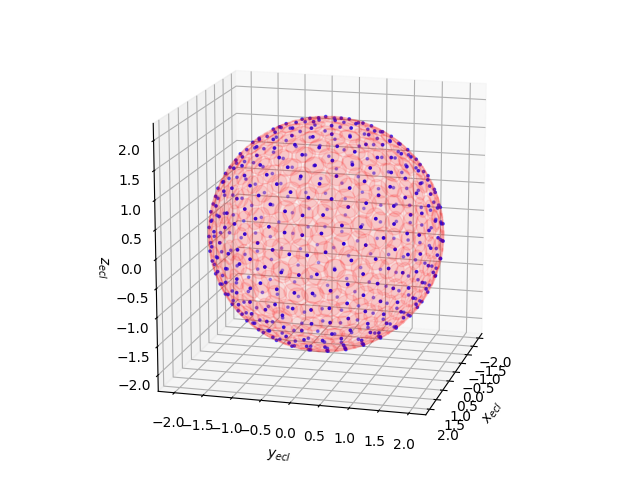

<IPython.core.display.Javascript object>


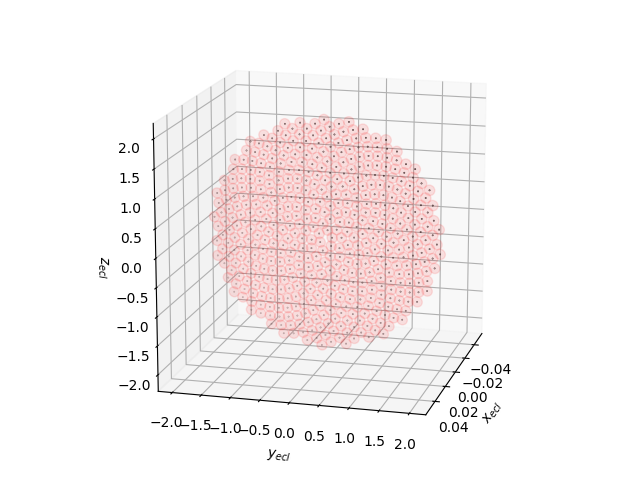

.
----------------------------------------------------------------------
Ran 1 test in 1.348s

OK


In [47]:
if IN_JUPYTER:
    def test_plot3d(self):
        Verbose.VERBOSITY=0
        sg=Spangler(nspangles=500,body_hash="123",n_equ=[1,1,1])
        sg.populate_spangler(geometry="sphere",scale=2,seed=1)
        sg.plot3d(c='b',s=3)
        
        sg=Spangler(nspangles=500,body_hash="123",n_equ=[1,0,0])
        sg.populate_spangler(geometry="circle",scale=2,seed=1,boundary=0)
        sg.plot3d()
        #sg.populate_spangler(geometry="ring",scale=2,seed=1,gaps=[[0,0.2],[0.5,0.1]],boundary=0)
        Verbose.VERBOSITY=0

        
    class Test(unittest.TestCase):pass
    Test.test_plot3d=test_plot3d
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [49]:
def plot_obs(self,spangled=dict(),**args):
    """
    Plot spangle.

    Parameters:
        args: scatter plotting options, dictionary.
    """
    sargs=dict(c='k',s=1.5)
    sargs.update(args)
    
    self.fig,self.ax=plt.subplots()
    self.ax.scatter(self.data.x_obs,self.data.y_obs,**sargs)
    self.ax.set_aspect("equal")
    self.fig.tight_layout()
    
Spangler.plot_obs=plot_obs

<IPython.core.display.Javascript object>


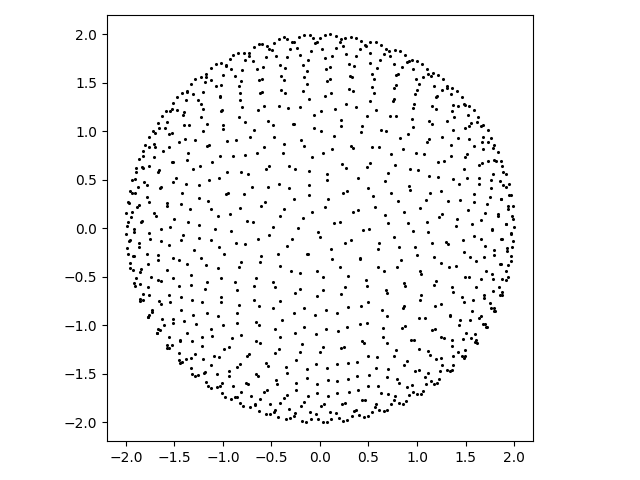

.
----------------------------------------------------------------------
Ran 1 test in 2.123s

OK


In [54]:
if IN_JUPYTER:
    def test_plotobs(self):
        Verbose.VERBOSITY=0
        sg=Spangler(nspangles=1000,body_hash="123",n_equ=[1,1,1])
        #sg.populate_spangler(geometry="ring",scale=2,seed=1,gaps=[[0,0.2],[0.5,0.1]],boundary=0)
        #sg.populate_spangler(geometry="circle",scale=2,seed=1,boundary=0)
        sg.populate_spangler(geometry="sphere",scale=2,seed=1)
        sg.update_positions(n_obs=[1,0,1])
        sg.plot_obs()
        
        Verbose.VERBOSITY=0

        
    class Test(unittest.TestCase):pass
    Test.test_plotobs=test_plotobs
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--

### Documentation

- https://stackoverflow.com/questions/63977848/assign-multiple-columns-of-numpy-to-one-pandas-dataframe-column